# Quick tutorial for the new simulation library

First you define the system.

In the system call definition you can specify if you want some verbosity. This essentially only controls whether the code should tell you when you update values and whether iterations use a simple for loop or if they use tqdm to check the progress.
Defaults to True

In [ ]:
from macrospinLib import *

verbose=True
exampleSystem=quasiEquilibriumSystem(verbose=verbose)

You then need to add the field terms. You do not need to specify anything, but everyhing will default to 0 if you do not. You never need to specify anything in the case of the external field.

Available static field are:     
-**externalField**. This simply add the external field to the system, but since the Bext params will need to be swept later you dont need to define the values      
-**demagField**. This adds the shape anisotropy / demag field to the effective field. Accepts Bdem and N (N is the diagonal of demag tensor as input)       
-**uniaxialField**. Adds a uniaxial anistropy field to the system. Accepts Ban, thetaAn and phiAn as input      
-**fourFoldField**. Adds an in-plane 4-fold anistropy field to the system. Accepts B4 and alpha as input        
-**biasField**. Adds a static bias field to the system. Accepts Bbias, thetaBias annd phiBias as variables      

Available current induced fields are:\
-**chargeCurrent**: adds the Oe field. Accepts B_Oe as input, _ALWAYS_ points along y       
-**spinAccumulation**: adds a spin acculumation to the system. Accepts thetaS and phiS as inputs        
-**fieldLikeTorque**: adds field-like torque to the system. Accepts Bfl as input, points along $\bm{s}$     
-**dampingLikeTorque**: adds damping-like torque to the system. Accepts Bdl as input, points along $\bm{m}\times\bm{s}$


In [ ]:
exampleSystem.externalField()                               #adds the external field
exampleSystem.demagField(Bdem=1.666,demagTensor=[0,0,1])      #adds the demag field. demagTensor is actually just the diagonal
exampleSystem.uniaxialField(Ban=0,thetaAn=0,phiAn=0)        #adds a uniaxial anistropy field

added value for Bext to 0T, phiB=0 degrees, thetaB= 0 degrees
Added value for Bdem to 1.666T, demag tensor diagonal to [0, 0, 1]
Added value for Ban to 0T, phiB=0 degrees, thetaB= 0 degrees


You can check the total effective field by calling the .totalEffectiveField() method, though this will leave everything in variable form

In [3]:
exampleSystem.totalEffectiveField()

(-B_dem)*Matrix([
[Nxx,   0,   0],
[  0, Nyy,   0],
[  0,   0, Nzz]])*Matrix([
[sin(theta)*cos(phi)],
[sin(phi)*sin(theta)],
[         cos(theta)]]) + B_ext*Matrix([
[sin(theta_B)*cos(phi_B)],
[sin(phi_B)*sin(theta_B)],
[           cos(theta_B)]]) + (B_an*(sin(phi)*sin(phi_An)*sin(theta)*sin(theta_An) + sin(theta)*sin(theta_An)*cos(phi)*cos(phi_An) + cos(theta)*cos(theta_An)))*Matrix([
[sin(theta_An)*cos(phi_An)],
[sin(phi_An)*sin(theta_An)],
[            cos(theta_An)]])

In [4]:
# You can fix it by calling the.subs routine and passing the appropriate dict
subsDict={'Nxx':0,'Nyy':0,'Nzz':1,'theta_An':0,'phi_An':0}
toLatex=exampleSystem.totalEffectiveField().subs(subsDict)
toLatex

(-B_dem)*Matrix([
[0, 0, 0],
[0, 0, 0],
[0, 0, 1]])*Matrix([
[sin(theta)*cos(phi)],
[sin(phi)*sin(theta)],
[         cos(theta)]]) + B_ext*Matrix([
[sin(theta_B)*cos(phi_B)],
[sin(phi_B)*sin(theta_B)],
[           cos(theta_B)]]) + (B_an*cos(theta))*Matrix([
[0],
[0],
[1]])

To add torques, you need to add chargeCurrent() and spinAccumulation(), then the relavant torques:

In [5]:
exampleSystem.chargeCurrent(B_Oe=1e-3)              #Here you only need to specify the Oersted field, which will ALWAYS point along y
exampleSystem.spinAccumulation(thetaS=90,phiS=90)   #spin accumulation you can specify any angle

# Damping-like and field-like torqes require a chargecurrent() and spinAccumulation() befor they can be called, and you can only spefify the intensity for the two
exampleSystem.dampingLikeTorque(Bdl=1e-3)             
exampleSystem.fieldLikeTorque(Bfl=1e-3)  


# When you call totalEffectiveField() all variables will remain unevaluated
exampleSystem.totalEffectiveField()

added value for BOe to 1.0mT
Added value for Bdl to 1.0mT
Added value for Bfl to 1.0mT


(-B_dem)*Matrix([
[Nxx,   0,   0],
[  0, Nyy,   0],
[  0,   0, Nzz]])*Matrix([
[sin(theta)*cos(phi)],
[sin(phi)*sin(theta)],
[         cos(theta)]]) + B_dl*Matrix([
[                   -j_c*sin(phi)*sin(theta)*cos(theta_S) + j_c*sin(phi_S)*sin(theta_S)*cos(theta)],
[                    j_c*sin(theta)*cos(phi)*cos(theta_S) - j_c*sin(theta_S)*cos(phi_S)*cos(theta)],
[j_c*sin(phi)*sin(theta)*sin(theta_S)*cos(phi_S) - j_c*sin(phi_S)*sin(theta)*sin(theta_S)*cos(phi)]]) + B_ext*Matrix([
[sin(theta_B)*cos(phi_B)],
[sin(phi_B)*sin(theta_B)],
[           cos(theta_B)]]) + B_fl*Matrix([
[j_c*sin(theta_S)*cos(phi_S)],
[j_c*sin(phi_S)*sin(theta_S)],
[           j_c*cos(theta_S)]]) + (B_Oe*j_c)*Matrix([
[0],
[1],
[0]]) + (B_an*(sin(phi)*sin(phi_An)*sin(theta)*sin(theta_An) + sin(theta)*sin(theta_An)*cos(phi)*cos(phi_An) + cos(theta)*cos(theta_An)))*Matrix([
[sin(theta_An)*cos(phi_An)],
[sin(phi_An)*sin(theta_An)],
[            cos(theta_An)]])

## Simulating Sweeps

There are two sweep implemented in: LLG sweeps and quasi-equilibrium sweeps. They both accept the same input parameters, but they also have some specific ones for them:

**_SHARED PARAMETERS_**

-**B_sweep**: either a single number, or an array of values. External field strenght for each simulation step. Defaults to 0 if left empty, if a single value is passed it is considered constant for all the sweep step

-**thetaB_sweep**: either a single number, or an array of values. External field polar angle for each simulation step. Defaults to 0 if left empty, if a single value is passed it is considered constant for all the sweep step

-**phiB_sweep**: either a single number, or an array of values. External field azimuthal angle for each simulation step. Defaults to 0 if left empty, if a single value is passed it is considered constant for all the sweep step

-**j_modulation**:  either a single number, or an array of values. Normalized current density for each simulation step. Defaults to 0 if left empty, if a single value is passed it is considered constant for all the sweep step. Normalized just means that the B_Oe, B_fl and B_dl that you set will actually have that instensity _ONLY_ for j_c=1 

-**timeSweep**: either a single number, or an array of values. Timesteps for each simulation step. Defaults to 0 if left empty, if a single value is passed it is considered constant for all the sweep step. In the LLGsim this is a crucial parameters, while for the quasiEqilibriumSweeps it is only useful as a plotting thingy

**_SWEEP-SPECIFIC PARAMETERS_-LLG**

-**initialPosition** : initial position for the time evolution. Defaults to [0,0]

-**showSweep**: Boolean True/False. ONLY shows the sweep as a function of timesweep. Defaults to False

-**alpha_G** : gilbert damping. Defaults to 0.01

-**gamma** : gyromagnetic ratio. Defaults to $1.76*10^{11} rad  \ s^{-1} \ T^{-1}$ 

**_SWEEP-SPECIFIT PARAMETERS_-quasiEq**

-**initialGuess**: initial guess. Not much to say about this

-**showSweep**: x axis over which to show the sweep. Accepts 'phi', 'theta', 'B' and 'time', or False. Defaults to False

-**switchGuess**: where the system should try to switch to if no equilibrium is reached or if the coercifity is reached. Accepts 'theta' (theta-->180-theta), 'phi' (phi-->180+phi), 'x' (mx-->-mx), 'y' (my-->-my), 'both' ((mx,my,mz)-->-(mx,my,mz)), or 'Bext' (new initial guess is aligned to external field, will then find the closest eq). Dafaults to 'Bext'

-**tol**: tolerance below which the net torque acting on the magnetization can be considered 0 (i.e $|\bm{m}\times\bm{B}_{eff}|^2\leq tol$). Dafaults to 1e-10, but you may need to change this for some sweeps

-**B_coer**: coercive field. Field at which the system will try to switch regardless of anything else. Defaults to some insanely high value, there just as a placeholder. Is symmetric (i.e, will switch when it crosses +B_coer and when it corsses -B_coer)


### LLG sweeps
In these, you solve the LLG equations at each timestep

100%|██████████| 10000/10000 [00:03<00:00, 3225.55it/s]


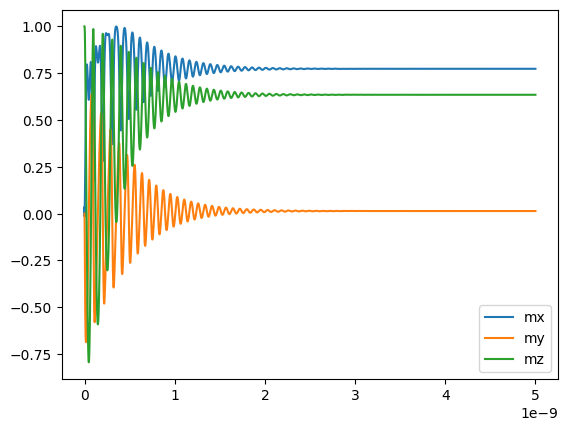

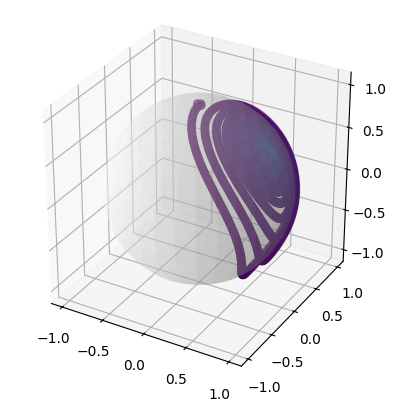

In [6]:
B_sweep=0.5
thetaB_sweep=80
phiB_sweep=1
j_c=0
timeSweep=np.linspace(0,5e-9,int(1e4))

#This returns two arrays, theta and phi
thetaOut,phiOut=exampleSystem.simulateLLG(B_sweep=B_sweep,thetaB_sweep=thetaB_sweep,phiB_sweep=phiB_sweep,j_modulation=j_c,timeSweep=timeSweep,initialPosition=[1,0],alpha_G=0.05,showSweep=True)

### Quasi equilibrium simulations

In these, you solve $|\bm{m}\times\bm{B}_{eff}|^2=0$

#### Example angle scan with out of plane tilt in measurement

In [ ]:
Bext=0.6        #define external field (in T)
phiB_sweep=np.array(0,360,360)  #define external field azimuthal angle (in deg)
deltaThetaB=5   #define external field polar angle misalignment  (in deg)
phiTheta0=0     # define angle of minimum thetaB misalignment
thetaB_sweep=90+deltaThetaB*np.sin(np.deg2rad(phiB_sweep-phiTheta0))    #define effective external field polar angle

# define the system parameters
exampleSystem=quasiEquilibriumSystem()
exampleSystem.externalField()
exampleSystem.demagField(Bdem=2.2)
exampleSystem.biasField(Bbias=0.2,thetaBias=90,phiBias=90)
exampleSystem.chargeCurrent(B_Oe=-0.5e-3)
exampleSystem.spinAccumulation(thetaS=90,phiS=90)
exampleSystem.fieldLikeTorque(Bfl=1e-3)
exampleSystem.dampingLikeTorque(Bdl=1e-3)

# j modulation = +1
thetaP,phiP=exampleSystem.sweep_equilibrium(B_sweep=Bext,thetaB_sweep=thetaB_sweep,phiB_sweep=phiB_sweep,j_modulation=1,initialGuess=[0,0],showSweep=False,switchGuess='theta',tol=1e-8)

# j modulation = -1
thetaM,phiM=exampleSystem.sweep_equilibrium(B_sweep=Bext,thetaB_sweep=thetaB_sweep,phiB_sweep=phiB_sweep,j_modulation=-1,initialGuess=[0,0],showSweep=False,switchGuess='theta',tol=1e-8)

In [ ]:
# deifne resistance parameters
PHE=1
AHE=0.5
OHE=0.3

# define an appropriate resistance function
R=lambda theta,phi,Bext,thetaExt: AHE*np.sin(np.deg2rad(theta))

#### Field scan for Niklas

updated value for Ban to 3T, phiB=0 degrees, thetaB= 0 degrees


 30%|███       | 602/2000 [00:02<00:07, 188.15it/s]

Coercive field reached. Attemping switching from [206.05614963 180.20885681] to [-26.05614962827582, 180.2088568056074]


 80%|███████▉  | 1595/2000 [00:06<00:02, 187.50it/s]

Coercive field reached. Attemping switching from [ 26.05596021 179.98296231] to [153.9440397880819, 179.98296231051336]


100%|██████████| 2000/2000 [00:07<00:00, 258.37it/s]


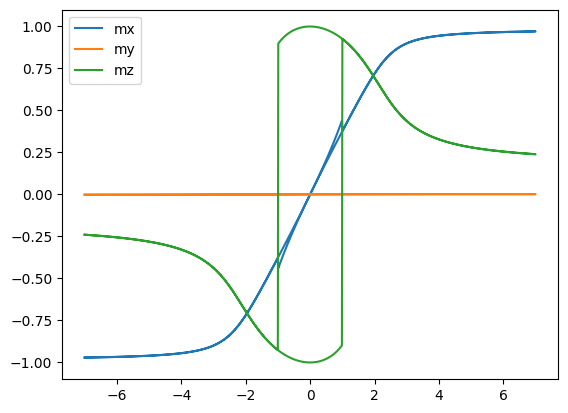

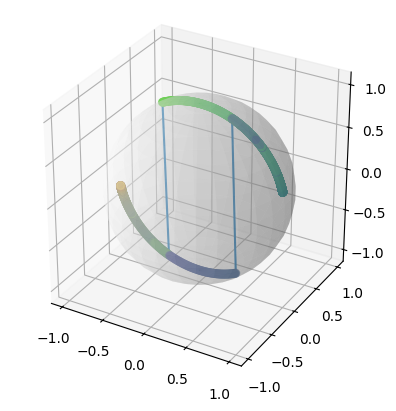

(array([103.85546964, 103.8660141 , 103.87661603, ..., 103.87661603,
        103.8660141 , 103.85546961]),
 array([180.07818455, 180.07814417, 180.07810365, ..., 180.07810365,
        180.07814417, 180.07818454]))

In [11]:
B_sweepFWD=np.linspace(-7,7,1000)
B_sweepBWD=np.linspace(7,-7,1000)

B_sweep=np.concatenate((B_sweepFWD,B_sweepBWD))
thetaB_sweep=80
phiB_sweep=0.1
j_modulation=1

exampleSystem.uniaxialField(Ban=3,thetaAn=0,phiAn=0)

# This also returns theta,phi
exampleSystem.sweep_equilibrium(B_sweep=B_sweep,thetaB_sweep=thetaB_sweep,phiB_sweep=phiB_sweep,j_modulation=j_modulation,initialGuess=[100,180],showSweep='B',switchGuess='theta',B_coer=1,tol=1e-8)

So you can do the usual thing for the AC/DC components:

In [12]:
exampleSystem.fourFoldField(0.5)

updated value for B4 to 0.5T, alpha to alpha


In [13]:
# j modulation = +1
thetaP,phiP=exampleSystem.sweep_equilibrium(B_sweep=B_sweep,thetaB_sweep=thetaB_sweep,phiB_sweep=phiB_sweep,j_modulation=1,initialGuess=[100,180],showSweep=False,switchGuess='theta',B_coer=1,tol=1e-8)

# j modulation = -1
thetaM,phiM=exampleSystem.sweep_equilibrium(B_sweep=B_sweep,thetaB_sweep=thetaB_sweep,phiB_sweep=phiB_sweep,j_modulation=-1,initialGuess=[100,180],showSweep=False,switchGuess='theta',B_coer=1,tol=1e-8)

 30%|███       | 605/2000 [00:02<00:07, 188.56it/s]

Coercive field reached. Attemping switching from [206.05614963 180.20885681] to [-26.05614962827582, 180.2088568056074]


 80%|████████  | 1605/2000 [00:06<00:02, 188.49it/s]

Coercive field reached. Attemping switching from [ 26.05596021 179.98296231] to [153.9440397880819, 179.98296231051336]


 30%|███       | 601/2000 [00:02<00:07, 188.46it/s]

Coercive field reached. Attemping switching from [206.12796914 179.98299799] to [-26.127969140023453, 179.9829979930624]


 80%|████████  | 1601/2000 [00:06<00:02, 188.24it/s]

Coercive field reached. Attemping switching from [ 26.12815803 180.20842174] to [153.87184196872798, 180.2084217441976]


100%|██████████| 2000/2000 [00:07<00:00, 258.29it/s]


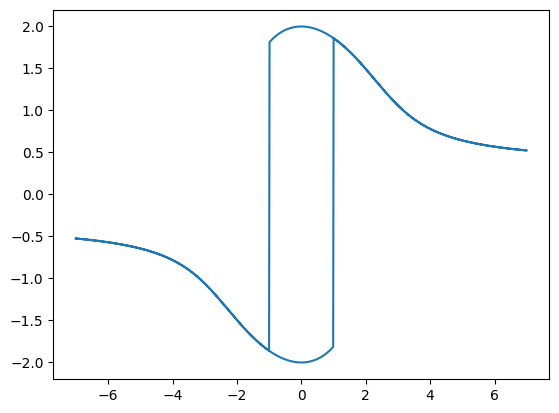

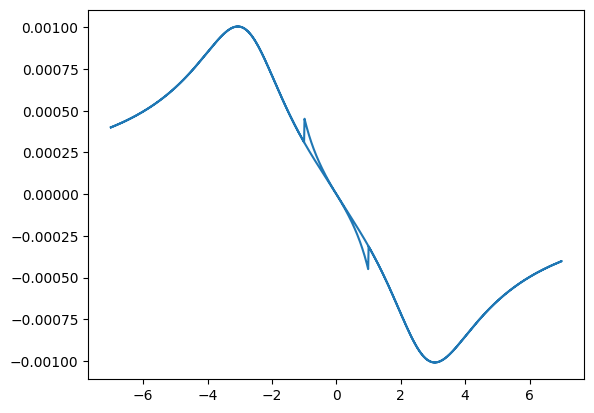

In [ ]:
RH=lambda theta,phi


mzP=np.cos(np.deg2rad(thetaP))
mzM=np.cos(np.deg2rad(thetaM))
plt.figure()
plt.plot(B_sweep,mzP+mzM)
plt.figure()
plt.plot(B_sweep,mzP-mzM)

## Printing pretty things in Latex

When you call totalEffectiveField() all variables will remain in variable form. To substitute the values, you can use the .subs(subsDict) method

In [5]:
# The free parameters can be obtained as:
exampleSystem.totalEffectiveField().free_symbols

{B_Oe,
 B_dem,
 B_dl,
 B_ext,
 B_fl,
 Nxx,
 Nyy,
 Nzz,
 j_c,
 phi,
 phi_B,
 phi_S,
 theta,
 theta_B,
 theta_S}

In [9]:
# You can then define a dictionary for values to substitute:
# NOTE: use sympy angles for substitution in this context: syp.pi, syp.pi/2 and so on
subsDict={'Nxx':0,'Nyy':0,'Nzz':1,'theta_S':syp.pi/2,'phi_S':syp.pi/2,'j_c':1}
toLatex=exampleSystem.totalEffectiveField().subs(subsDict)
toLatex

B_Oe*Matrix([
[0],
[1],
[0]]) + (-B_dem)*Matrix([
[0, 0, 0],
[0, 0, 0],
[0, 0, 1]])*Matrix([
[sin(theta)*cos(phi)],
[sin(phi)*sin(theta)],
[         cos(theta)]]) + B_dl*Matrix([
[          cos(theta)],
[                   0],
[-sin(theta)*cos(phi)]]) + B_ext*Matrix([
[sin(theta_B)*cos(phi_B)],
[sin(phi_B)*sin(theta_B)],
[           cos(theta_B)]]) + B_fl*Matrix([
[0],
[1],
[0]])

When you are happy with the results, you can just do the following to get everything in latex form:

In [10]:
print(str(syp.latex(toLatex)))

B_{Oe} \left[\begin{matrix}0\\1\\0\end{matrix}\right] + - B_{dem} \left[\begin{matrix}0 & 0 & 0\\0 & 0 & 0\\0 & 0 & 1\end{matrix}\right] \left[\begin{matrix}\sin{\left(\theta \right)} \cos{\left(\phi \right)}\\\sin{\left(\phi \right)} \sin{\left(\theta \right)}\\\cos{\left(\theta \right)}\end{matrix}\right] + B_{dl} \left[\begin{matrix}\cos{\left(\theta \right)}\\0\\- \sin{\left(\theta \right)} \cos{\left(\phi \right)}\end{matrix}\right] + B_{ext} \left[\begin{matrix}\sin{\left(\theta_{B} \right)} \cos{\left(\phi_{B} \right)}\\\sin{\left(\phi_{B} \right)} \sin{\left(\theta_{B} \right)}\\\cos{\left(\theta_{B} \right)}\end{matrix}\right] + B_{fl} \left[\begin{matrix}0\\1\\0\end{matrix}\right]


You can technically see the function to minimize by calling the following, but I dont reccomend it

In [8]:
tSqr=exampleSystem.totalEffectiveField(evaluate=True).cross(exampleSystem.m).dot(exampleSystem.totalEffectiveField(evaluate=True).cross(exampleSystem.m))
tSqr

(-(B_an*(sin(phi)*sin(phi_An)*sin(theta)*sin(theta_An) + sin(theta)*sin(theta_An)*cos(phi)*cos(phi_An) + cos(theta)*cos(theta_An))*cos(theta_An) - B_dem*Nzz*cos(theta) + B_dl*(j_c*sin(phi)*sin(theta)*sin(theta_S)*cos(phi_S) - j_c*sin(phi_S)*sin(theta)*sin(theta_S)*cos(phi)) + B_ext*cos(theta_B) + B_fl*j_c*cos(theta_S))*sin(phi)*sin(theta) + (B_Oe*j_c + B_an*(sin(phi)*sin(phi_An)*sin(theta)*sin(theta_An) + sin(theta)*sin(theta_An)*cos(phi)*cos(phi_An) + cos(theta)*cos(theta_An))*sin(phi_An)*sin(theta_An) - B_dem*Nyy*sin(phi)*sin(theta) + B_dl*(j_c*sin(theta)*cos(phi)*cos(theta_S) - j_c*sin(theta_S)*cos(phi_S)*cos(theta)) + B_ext*sin(phi_B)*sin(theta_B) + B_fl*j_c*sin(phi_S)*sin(theta_S))*cos(theta))**2 + ((B_an*(sin(phi)*sin(phi_An)*sin(theta)*sin(theta_An) + sin(theta)*sin(theta_An)*cos(phi)*cos(phi_An) + cos(theta)*cos(theta_An))*cos(theta_An) - B_dem*Nzz*cos(theta) + B_dl*(j_c*sin(phi)*sin(theta)*sin(theta_S)*cos(phi_S) - j_c*sin(phi_S)*sin(theta)*sin(theta_S)*cos(phi)) + B_ext*cos(t

# Stoner Wolfhart

In [8]:
exampleSystem.staticAttributes

{'B_an': 1,
 'B_dem': 0.5,
 'B_ext': -1.0,
 'Nxx': 0,
 'Nyy': 0,
 'Nzz': 1,
 'phi_An': 0.0,
 'phi_B': 1.5707963267948966,
 'theta_An': 0.0,
 'theta_B': 0.0,
 'verbose': True}

In [7]:
phiB=0
thetaB=90

B_sweep=np.linspace(-1,1,1000)

exampleSystem.stonerWolfhart(B_sweep=B_sweep,thetaB_sweep=thetaB,phiB_sweep=phiB,showSweep='B')

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[(0.0, phi), (3.14159265358979, phi)]


TypeError: list indices must be integers or slices, not Symbol